In [1]:
import time
tp1 = time.time()

In [2]:
# Some magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
# Ignore warnings in notebook
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Matplotlib to plot the data
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [5]:
# Some module needed in the notebook
import numpy as np
import javabridge
import bioformats
from itkwidgets import view
from sklearn.externals import joblib

In [6]:
# Create a temporary python PATH to the module that we are using for the analysis
import sys
sys.path.insert(0, "/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/ChromosomeDetectionChloe/utils")

In [7]:
from chromosome_dsb import *

In [8]:
# Need to create a javabridge to use bioformats to open proprietary format
javabridge.start_vm(class_path=bioformats.JARS)

In [9]:
path_data = '//Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/data_chloe/cku-exo1_002/'

In [10]:
position, time_point = load_data.stage_position(path_data)

# Set Parameters

In [11]:
# Size kernel for background substraction, should be a little larger than the object of interest
back_sub_ch1 = 5
back_sub_ch2 = 5
back_sub_ch3 = 20
# FOCI detection:
# Smallest object (in pixels) to be detected
smaller = 1
# Largest object to be detected
largest = 5
# Threshold above which to look for
thresh = 60

# Find "Skeleton" of gonad

In [12]:
skelete = load_data.skeleton_coord(position,time_point)

Polyfit may be poorly conditioned


# Load Image

In [13]:
path_img = path_data + '/2017-04-12_RAD51-HTP3_cku80-exo1_002_visit_13_D3D_ALX.dv'

In [14]:
image, meta, directory = load_data.load_bioformats(path_img)

# Plot "Skeleton" of gonad

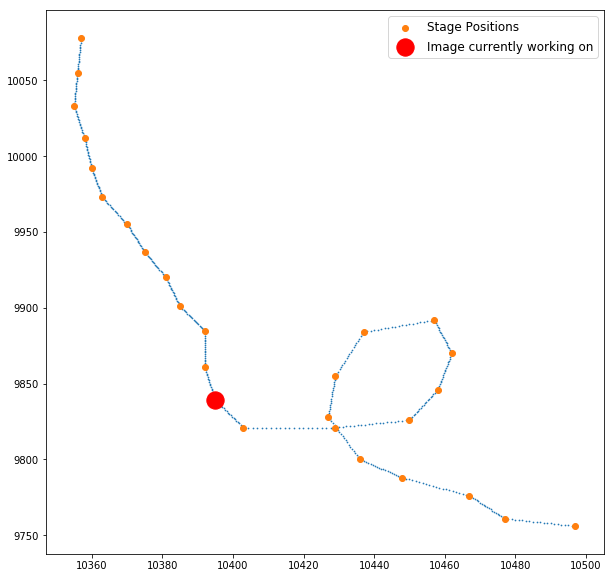

In [15]:
data = np.concatenate((position,time_point[:, np.newaxis]), axis=1)
sort_data = data[np.argsort(data[:,2])]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(skelete[:,0], skelete[:,1], s=0.5)
stage_pos = ax.scatter(sort_data[:,0], sort_data[:,1])
working_on = ax.scatter(meta["PositionX"], meta["PositionY"], s=300, color = "r")
plt.legend([stage_pos, working_on], ["Stage Positions", 
                                     "Image currently working on"],
                                      loc=0,fontsize='large')

In [16]:
img = image[:,:,:,3]

In [17]:
view(visualization.convert_view(img))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUS3; proxy of <Swig Object of type 'itkIm…

# Find the nucleus in the image

### First need to load the classifier (clf) 

In [18]:
clf = joblib.load("/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/ChromosomeDetectionChloe/clf_scaler/clf")
scaler = joblib.load("/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/ChromosomeDetectionChloe/clf_scaler/scaler")

In [ ]:
tp_1 = time.time()
result = search.rolling_window(img, clf, scaler)
tp_2 = time.time()
print(tp_2-tp_1)

In [ ]:
bbox_ML = search.non_max_suppression(result, probaThresh=0.01, overlapThresh=0.3)

# Background Substraction

In [ ]:
ch1, _ = img_analysis.background_correct(image, ch=1, size=back_sub_ch1)
ch2, _ = img_analysis.background_correct(image, ch=2, size=back_sub_ch2)
ch3, _ = img_analysis.background_correct(image, ch=3, size=back_sub_ch3)

In [ ]:
visualization.plot_background(image, ch1, ch2, ch3)

# Finding the Blobs/FOCI

In [ ]:
blobs = img_analysis.find_blob(ch1, smaller = smaller, 
                               largest = largest, thresh = thresh,
                               view=True)

# Binarization of the Channel with nucleus

In [ ]:
binary = img_analysis.binarization(ch3)

In [ ]:
view(visualization.convert_view(binary))

# Load the position of the different nucleus

In [ ]:
#bbox_ML = np.load("/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/13/bbox_3D.npy")

# Mask FOCI that are not on the nucleus

In [ ]:
masked = img_analysis.find_foci(blobs, ch3, binary)

# Mask FOCI that are not on a nucleus found by the Machine Learning

In [ ]:
res, bb_mask = search.binary_select_foci(bbox_ML, ch3, masked)

# Find and remove FOCI that were counted twice

In [ ]:
num, cts, dup_idx, mask = search.find_duplicate(res)

In [ ]:
visualization.plot_result(img, res, bbox_ML, bb_mask,\
                          cts, num, meta, directory, save = True)

In [ ]:
dist_tip = img_analysis.distance_to_tip(bbox_ML[bb_mask], skelete, meta)

In [ ]:
img_analysis.final_table(meta, bbox_ML, bb_mask, \
                         dist_tip, cts, num, \
                         directory, save = True)

In [ ]:
to_save = {'back_sub_ch1' : back_sub_ch1,
           'back_sub_ch2' : back_sub_ch2,
           'back_sub_ch3' : back_sub_ch3,
           'small_object' : smaller,
           'large_object' : largest,
           'threshold' : thresh}

log.log_file(directory, meta, **to_save)

In [ ]:
tp2 = time.time()

In [ ]:
print("It took {}sec".format(int(tp2-tp1)))